<a href="https://colab.research.google.com/github/Prashanth0703/ML/blob/master/MNISTusingCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf

In [1]:
# Import TensorFlow Datasets
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

# Helper libraries
import math
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [5]:
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.0.incompleteVP4XLE/fashion_mnist-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.0.incompleteVP4XLE/fashion_mnist-test.tfrecord
Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.0. Subsequent calls will reuse this data.


In [6]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']

In [7]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples:     {}".format(num_test_examples))

Number of training examples: 60000
Number of test examples:     10000


In [8]:
def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

# The map function applies the normalize function to each element in the train
# and test datasets
train_dataset =  train_dataset.map(normalize)
test_dataset  =  test_dataset.map(normalize)

# The first time you use the dataset, the images will be loaded from disk
# Caching will keep them in memory, making training faster
train_dataset =  train_dataset.cache()
test_dataset  =  test_dataset.cache()

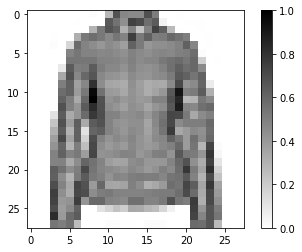

In [9]:
# Take a single image, and remove the color dimension by reshaping
for image, label in test_dataset.take(1):
  break
image = image.numpy().reshape((28,28))

# Plot the image - voila a piece of fashion clothing
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

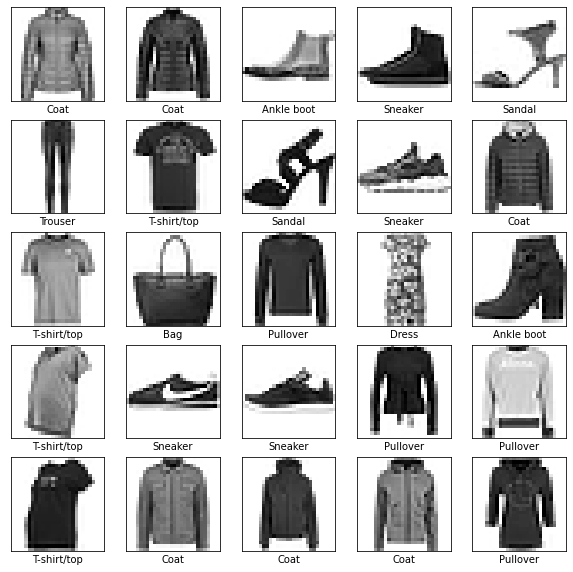

In [10]:
plt.figure(figsize=(10,10))
i = 0
for (image, label) in test_dataset.take(25):
    image = image.numpy().reshape((28,28))
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(class_names[label])
    i += 1
plt.show()

#Here the only change is we introduce cnns

In [11]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [12]:
BATCH_SIZE = 32
train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

Here its 10 epochs!

In [15]:
model.fit(train_dataset, epochs=10, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.3986 - accuracy: 0.8572
Epoch 2/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2626 - accuracy: 0.9049
Epoch 3/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2147 - accuracy: 0.9211
Epoch 4/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1837 - accuracy: 0.9332
Epoch 5/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1555 - accuracy: 0.9414
Epoch 6/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1312 - accuracy: 0.9512
Epoch 7/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1129 - accuracy: 0.9581
Epoch 8/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0959 - accuracy: 0.9645
Epoch 9/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0766 - accuracy: 0.9714
Epoch 10/10
1875/1875 [==============================] - 10s 5ms/step - l

In [16]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))
print('Accuracy on test dataset:', test_accuracy)

313/313 [==============================] - 3s 9ms/step - loss: 0.3106 - accuracy: 0.9199
Accuracy on test dataset: 0.9199000000953674


In [17]:
for test_images, test_labels in test_dataset.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

In [18]:
predictions.shape

(32, 10)

In [19]:
predictions[0]

array([1.5974873e-09, 1.9340050e-11, 7.0186099e-05, 1.7519798e-11,
       9.9711573e-01, 6.9383601e-09, 2.8141905e-03, 1.2923552e-09,
       5.6717531e-10, 2.1787177e-09], dtype=float32)

In [24]:
np.argmax(predictions[0])

4

So the model is usually most confident that this image is a Shirt, or `class_names[6]`. Let's check the label:

In [25]:
test_labels[0]

4

In [26]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)
  
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

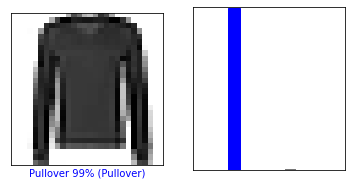

In [27]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

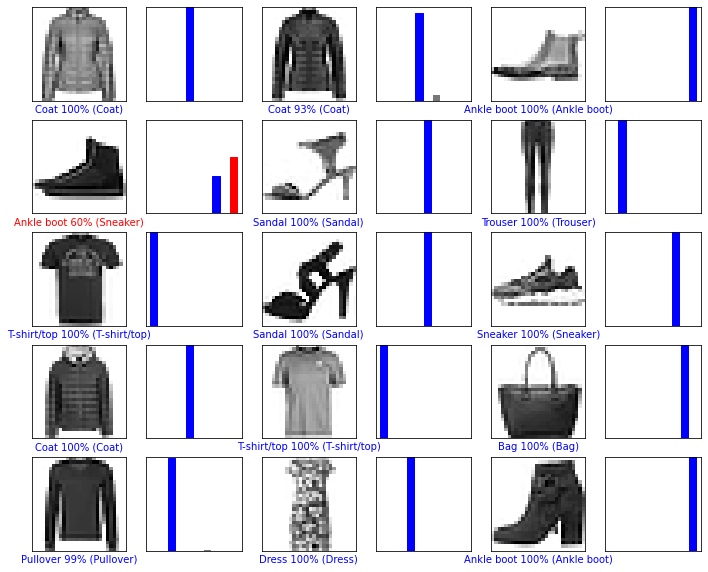

In [28]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)

In [ ]:
# Grab an image from the test dataset
img = test_images[0]

print(img.shape)

In [ ]:
# Add the image to a batch where it's the only member.
img = np.array([img])

print(img.shape)

Rest are the same!